# **Instructions**

This document is a template, and you are not required to follow it exactly. However, the kinds of questions we ask here are the kinds of questions we want you to focus on. While you might have answered similar questions to these in your project presentations, we want you to go into a lot more detail in this write-up; you can refer to the Lab homeworks for ideas on how to present your data or results. 

You don't have to answer every question in this template, but you should answer roughly this many questions. Your answers to such questions should be paragraph-length, not just a bullet point. You likely still have questions of your own -- that's okay! We want you to convey what you've learned, how you've learned it, and demonstrate that the content from the course has influenced how you've thought about this project.

# Project Name
Project mentor: Mark Dredze

Weiyao Wang <wwang121@jh.edu>, Junjie Yang <jyang173@jh.edu>, Team member <jhed1@jh.edu>

https://github.com/Wangweiyao/ML2020Fall

# Outline and Deliverables

List the deliverables from your project proposal. For each uncompleted deliverable, please include a sentence or two on why you weren't able to complete it (e.g. "decided to use an existing implementation instead" or "ran out of time"). For each completed deliverable, indicate which section of this notebook covers what you did.

If you spent substantial time on any aspects that weren't deliverables in your proposal, please list those under "Additional Work" and indicate where in the notebook you discuss them.

### Uncompleted Deliverables
1. "Expect to complete #1": Add extra ensemble methods other than simple average over all the submodels.
2. "Expect to complete #1": Come up with our novel feature selection or sample reweighting method.


### Completed Deliverables
1. "Must complete #1": We scaled the weights of each sample based on the learning trajectory [in "Methods" below](#scrollTo=zFq-_D0khnhh&line=10&uniqifier=1).
2. "Must complete #2": We performed correlation based feature selection & random shuffling based feature selection methods [in "Methods" below](#scrollTo=oMyqHUa0jUw7&line=5&uniqifier=1).
3. "Must complete #3": We applied the sample reweighting and feature selection methods to two base learner(GBT & MLP)


### Additional Deliverables
1. We decided to add the soft labelling. We discuss this [in "Methods" below](#scrollTo=oMyqHUa0jUw7&line=5&uniqifier=1).

# Preliminaries

## What problem were you trying to solve or understand?

What are the real-world implications of this data and task? If we can learn this problem well, we can understand if efficient market hypothesis is valid in this particular market. We also examine the effectiveness of recent methods proposed to work on financial data.

How is this problem similar to others we’ve seen in lectures, breakouts, and homeworks? This is problem can be framed as a supervised classification problem which we've seen a lot in this class.

What makes this problem unique?
It is different in that it's a time series prediction problem. The way we label it makes it imbalanced. And it is relatively hard (low accuracy is expected).

What ethical implications does this problem have?
Not Applied.

In [28]:
#!python3 -m pip install -e .. -U
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm, trange
from copy import deepcopy

## Dataset(s)

Describe the dataset(s) you used. 

How were they collected? We collect minute level bitcoin kline data from fmz.com

Why did you choose them? This is most ready dataset for bitcoin currently

How many examples in each? In total 988483 entries


In [2]:
TZ = 'Asia/Shanghai'
data_path = './data/data'
data_platform = 'BITFINEX'
data_symbol = 'BTC'

pkl_file_path = data_path+'/'+data_symbol+'_USD_'+data_platform+'_latest.pkl'
data = pd.read_pickle(pkl_file_path)

In [3]:
data

,open,high,low,close,volume
2019-01-01 16:00:00+08:00,3850.000000,3850.00000,3849.600000,3849.60000,0.443293
2019-01-01 16:01:00+08:00,3849.500000,3853.00000,3849.400000,3853.00000,9.085920
2019-01-01 16:02:00+08:00,3853.000000,3857.00000,3852.960000,3853.20000,8.213360
2019-01-01 16:03:00+08:00,3853.000000,3853.10000,3851.200000,3852.20000,6.385190
2019-01-01 16:04:00+08:00,3852.200000,3852.30000,3852.200000,3852.30000,0.504622
...,...,...,...,...,...
2020-12-07 15:55:00+08:00,19398.841056,19402.00000,19398.841056,19402.00000,8.340088
2020-12-07 15:56:00+08:00,19402.690321,19418.62931,19402.690321,19418.62931,2.047179
2020-12-07 15:57:00+08:00,19412.000000,19419.00000,19412.000000,19419.00000,0.153671
2020-12-07 15:58:00+08:00,19410.000000,19414.00000,19410.000000,19414.00000,0.633814


## Pre-processing

What features did you use or choose not to use? Why? We choose to use moving average and standard deviation across different time horizons. We are using these features because we believe they capture most information in historical price trend

If you have categorical labels, were your datasets class-balanced? It is not balanced. Positive class is 3-5%

How did you deal with missing data? What about outliers? We dont have missing data. We implicitly handle outliers in our sampling reweighting scheme that will be introduced later

What approach(es) did you use to pre-process your data? Why? We generate labels ourselves by setting a threshould on return rate in a given time horizon. Specifically, if the return is more than 1% in 1 hour, we will have it labled as positive in this study

Are your features continuous or categorical? How do you treat these features differently? We convert our continuous feature into (5) discrete bins to improve robustness (to noise / outliers)

#### Generate feaure

In [4]:
# Prepare features
import talib

# Moving averages
data['ma5m'] = talib.MA(data['close'], timeperiod = 5) / data['close'] 
data['ma10m'] = talib.MA(data['close'], timeperiod = 10) / data['close'] 
data['ma1h'] = talib.MA(data['close'], timeperiod = 60) / data['close'] 
data['ma4h'] = talib.MA(data['close'], timeperiod = 240) / data['close'] 
data['ma12h'] = talib.MA(data['close'], timeperiod = 720) / data['close'] 
data['ma1d'] = talib.MA(data['close'], timeperiod = 1440) / data['close']
data['ma5d'] = talib.MA(data['close'], timeperiod = 7200) / data['close'] 
data['ma10d'] = talib.MA(data['close'], timeperiod = 14400) / data['close'] 
data['ma30d'] = talib.MA(data['close'], timeperiod = 43200) / data['close'] 


# Standard deviation
data['std5m'] = talib.STDDEV(data['close'], timeperiod=5)/ data['close'] 
data['std10m'] = talib.STDDEV(data['close'], timeperiod = 10) / data['close'] 
data['std1h'] = talib.STDDEV(data['close'], timeperiod = 60) / data['close'] 
data['std4h'] = talib.STDDEV(data['close'], timeperiod = 240) / data['close'] 
data['std12h'] = talib.STDDEV(data['close'], timeperiod = 720) / data['close'] 
data['std1d'] = talib.STDDEV(data['close'], timeperiod = 1440) / data['close']
data['std5d'] = talib.STDDEV(data['close'], timeperiod = 7200) / data['close'] 
data['std10d'] = talib.STDDEV(data['close'], timeperiod = 14400) / data['close'] 
data['std30d'] = talib.STDDEV(data['close'], timeperiod = 43200) / data['close'] 

# Closeness to hundred / thousand
data['dis100'] = (data['close'] % 100) / 100 
data['dis1000'] = (data['close'] % 1000) / 1000 

/home/weiyao/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/weiyao/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


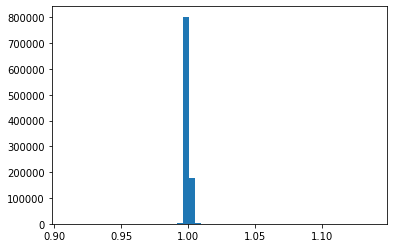

In [6]:
_ = plt.hist(data['ma5m'],bins=50)

In [7]:
train_start_time = pd.Timestamp('2019-01-01', tz=TZ)
train_end_time = pd.Timestamp('2020-4-1', tz=TZ)
val_start_time = pd.Timestamp('2020-4-1', tz=TZ)
val_end_time = pd.Timestamp('2020-08-01', tz=TZ)
test_start_time = pd.Timestamp('2020-08-01', tz=TZ)
test_end_time = pd.Timestamp('2020-12-31', tz=TZ)

train_data = data.loc[train_start_time:train_end_time]
val_data = data.loc[val_start_time:val_end_time]
test_data = data.loc[test_start_time:test_end_time]

#### Generate labels and train / val / test split

In [29]:
data['up_x%_in_future_1h'] = 100 * (data['close'].shift(-60) / data['close'] - 1)
data['up_x%_in_past_1h'] = 100 * (data['close'] / data['close'].shift(60) - 1)
data = deepcopy(data.dropna())

In [30]:
train_start_time = pd.Timestamp('2019-01-01', tz=TZ)
train_end_time = pd.Timestamp('2020-4-1', tz=TZ)
val_start_time = pd.Timestamp('2020-4-1', tz=TZ)
val_end_time = pd.Timestamp('2020-08-01', tz=TZ)
test_start_time = pd.Timestamp('2020-08-01', tz=TZ)
test_end_time = pd.Timestamp('2020-12-31', tz=TZ)

train_data = data.loc[train_start_time:train_end_time]
val_data = data.loc[val_start_time:val_end_time]
test_data = data.loc[test_start_time:test_end_time]

In [31]:
label = ['up_x%_in_future_1h']
positive_threshold = 1

#Train
y_train = (train_data[label].values > positive_threshold).astype(int)
#Val
y_val = (val_data[label].values > positive_threshold).astype(int)
#Test
y_test = (test_data[label].values > positive_threshold).astype(int)

In [32]:
print(f'Positive ratio in train set: {np.sum(y_train) / y_train.size}')
print(f'Positive ratio in val set: {np.sum(y_val) / y_val.size}')
print(f'Positive ratio in test set: {np.sum(y_test) / y_test.size}')

Positive ratio in train set: 0.05260440656175817
Positive ratio in val set: 0.03720489712436302
Positive ratio in test set: 0.03672479437001188


#### Discritize continuous features

In [49]:
feature_set = ['ma5m','ma10m','ma1h','ma4h','ma12h','ma1d','ma5d','ma10d','ma30d', \
               'std5m','std10m','std1h','std4h','std12h','std1d','std5d','std10d','std30d',\
               'dis100', 'dis1000']

X_train = train_data[feature_set].values.squeeze().astype(np.float32)
X_val = val_data[feature_set].values.squeeze().astype(np.float32)
X_test = test_data[feature_set].values.squeeze().astype(np.float32)

from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est.fit(X_train)

X_train = est.transform(X_train)
X_val = est.transform(X_val)
X_test = est.transform(X_test)

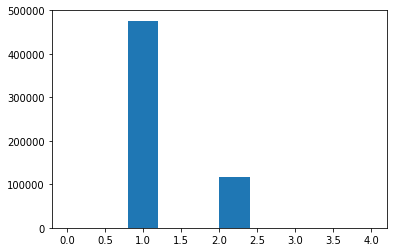

In [50]:
_ = plt.hist(X_train[:,0])

In [54]:
X_train[:,0].min()

0.0

In [55]:
X_train[:,0].max()

4.0

# Models and Evaluation

## Experimental Setup

How did you evaluate your methods? Why is that a reasonable evaluation metric for the task? We AUROC to evalaute performance. This is reasonable because our dataset is biased towards negative class so that accuracy would be not very informative

What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not? As shown below in methods we use a couple variants of training procedures. MLP are trained on cross entropy for eaxmple

How did you split your data into train and test sets? Why? We split it based on time to make sure there are no information leaked from training to validation / testing
Train split: 19/1/1 to 20/3/31
 Validation split: 20/4/1 to 20/7/31
Test split: 20/8/1 to 20/12/7


In [56]:
y_test_baseline_score = test_data['up_x%_in_past_1h'].values.squeeze().astype(np.float32)

In [57]:
def plot_roc(labels, scores):
    lw = 2
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='(AUC = %0.3f)' % (roc_auc))
    #plt.plot([eer], [1-eer], marker='o', markersize=5, color="navy")
    #plt.plot([0, 1], [1, 0], color='navy', lw=1, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")

## Baselines 

What baselines did you compare against? Why are these reasonable? We have a simple baseline that was suggested by the professor: use the return over the past 1 hour as a score to predict. We show the result below. It only gets an AUC of 0.492 showing that it is not performing well

Did you look at related work to contextualize how others methods or baselines have performed on this dataset/task? If so, how did those methods do? In the experiement result secection, we include base learners and ensembles. These are also considered as baseline methods that have been visited by other works as well

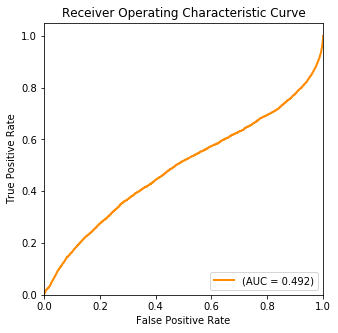

In [59]:
plot_roc(y_test, y_test_baseline_score)

## Methods

What methods did you choose? Why did you choose them?

Feature Selection:

We investigated 2 feature selection methods: 1. correlation based; 2. random shuffling based.

As for the random shuffling based method, the intuition behind is that if the value of a numerical feature is shuffled over N samples, this feature is rendered useless. And, if the loss of each sample does not change too much, then that means this feature is not important and we'd better remove it. To be more specific, after we fitted a base model(either GBT or MLP), we compute the loss L(Nx1 vector).We shuffle the f-th column of the training data X(NxF matrix, N: number of samples; F: number of features), and we re-input this shuffled X matrix into the trained model. And then we compute the negative log likehood of each sample(each row of X) Lf, which is a Nx1 vector. By ranking the value of |L-Lf|, we rank the importance of the features. And we divided the ranked features in to D bins. For each bin d belongs to D, we select r of the features out of that bin. r

How did you train these methods, and how did you evaluate them? Why?

During each training iteration, we first fit the weak learner(either GBT or MLP). Based on the resultant model, we reweight the samples and selected useful features by the above mentioned methods before we went on to the next iteration. 

We evaluated these methods by comparing the predictions of our model with the one before we applied our FS/SR methods.

Which methods were easy/difficult to implement and train? Why?

For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?

In terms of feature selection. We can adjust the ratio of selected features to the total number of features. But we didn't really try too many hyperparameters for sake of computational cost.

In [ ]:
# Code for training models, or link to your Git repository

https://github.com/Wangweiyao/ML2020Fall

In [ ]:
# Show plots of how these models performed during training.
#  For example, plot train loss and train accuracy (or other evaluation metric) on the y-axis,
#  with number of iterations or number of examples on the x-axis.

## Results

Show tables comparing your methods to the baselines.

What about these results surprised you? Why?

Did your models over- or under-fit? How can you tell? What did you do to address these issues?

What does the evaluation of your trained models tell you about your data? How do you expect these models might behave differently on different data?  

In [ ]:
# Show plots or visualizations of your evaluation metric(s) on the train and test sets.
#   What do these plots show about over- or under-fitting?
#   You may borrow from how we visualized results in the Lab homeworks.
#   Are there aspects of your results that are difficult to visualize? Why?

By monitoring the accuracy change of the validation set along the training path, we can make sure that our models are not over/under fitting with our current parameters

| | 1 model | 5 model | 5 model + correlation FS | 5 model + shuffle FS | Last 3 model + shuffle FS | Last 1 model + shuffle FS | 5 model + SR | Last 3 model + SR | Last 1 model + SR | 5 model + SR + shuffle FS | Last 3 model + SR + shuffle FS |  Last 1 model + SR + shuffle FS |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| GBT | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| MLP + soft label | 0.578 | 0.620 | 0.629 | 0.628 | 0.620 | 0.637 | 0.638 | 0.609 | 0.583 | 0.660 | 0.626 | 0.606 |
| MLP + hard label| 0.638 | 0.650 | 0.629 | 0.627 | 0.618 | 0.603 | 0.634 | 0.619 | 0.603 | 0.627 | 0.619 | 0.659 |

We can draw the following conclusion out the above table:
1. 5 model's ensemble is better than a single model
2. In the MLP+soft label case, feature selection & sample reweighting apparently improve the model performance. What's more, their combination increases the prediction accuracy to a even greater degree.
3. In the MLP+hard label case, feature selection & sample reweighting don't seem to be as useful. However, the accuracy of the last model is quite high, which means the performance was still improving during the training so this model might be underfitted.

# Discussion

## What you've learned

*Note: you don't have to answer all of these, and you can answer other questions if you'd like. We just want you to demonstrate what you've learned from the project.*

What concepts from lecture/breakout were most relevant to your project? How so? Decision trees/Neural Networks/Feature selections/bias-variance trade off. Following the same idea of the feauture selection we learned from this class, we applied it and see a big improvement in performance. We tried to select out the most informative features. The difference is all about the metric. Instead of using information gain, we used the idea of random shuffling to evaluate the importance of each features.

What aspects of your project did you find most surprising? The effectiveness of vanilla correlation feature selection. We did not think it would introduce much improvement.

What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not? 

What was the most helpful feedback you received during your presentation? Why? The one asks about how to weight different sub model. Because we do see the performance of each sub model vary by a lot. So this is very relevant.

If you had two more weeks to work on this project, what would you do next? Why? We would spend time to conduct more testing targeting feature selection because this looks more influential than we thought. We would also apply a more suitable ensemble method other than simple average. Because from the table shown in the above result section. We found that the submodels are not performing equally well. For example, in the MLP+soft label case, we observed that the submodel performance was decaying going forward, but in the MLP+hard label case, the last submodel outperformed all those before it. So if we asign a proper weight to different submodels, we can potentially improve the overall performance of the algorithm.